# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd
import re
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.shape

(47331, 17)

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
nan_values = df_reviews.isnull().sum()
print(nan_values)

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [9]:
print(f"La cantidad de filas duplicadas es: {df_reviews.duplicated().sum()}.")
print(f"El porcentaje de filas duplicadas es: {df_reviews.duplicated().sum()/len(df_reviews):.2%}.")

La cantidad de filas duplicadas es: 0.
El porcentaje de filas duplicadas es: 0.00%.


0    23715
1    23616
Name: pos, dtype: int64
0    0.501046
1    0.498954
Name: pos, dtype: float64


<AxesSubplot:>

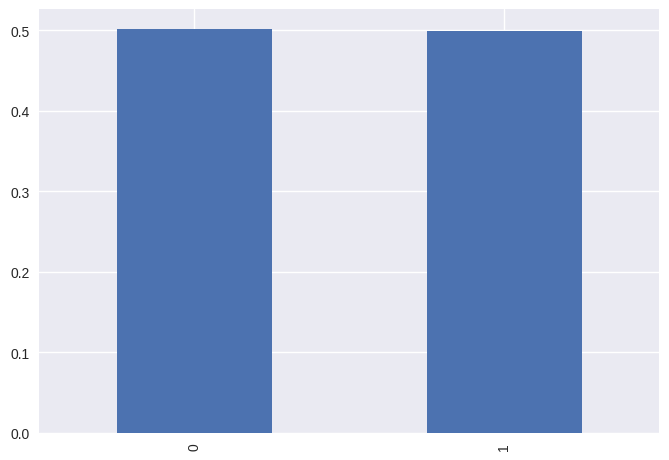

In [10]:
class_frequency = df_reviews['pos'].value_counts(normalize=True)
print(df_reviews['pos'].value_counts())
print(class_frequency)
class_frequency.plot(kind='bar')

In [11]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


### Observaciones
***
Hay un total de 47.331 observaciones.

Cada observación del conjunto de datos contiene datos sobre una película o serie y su reseña.

Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).
La información que se proporciona es la siguiente:


**Características:**

<code style="background:grey;color:black">tconst</code> : 
<br>
<code style="background:grey;color:black">title_type </code> : 
<br>
<code style="background:grey;color:black">original_title</code> : 
<br>
<code style="background:grey;color:black">start_year</code> : 
<br>
<code style="background:grey;color:black">end_year</code> :
<br>
<code style="background:grey;color:black">runtime_minutes</code> : 
<br>
<code style="background:grey;color:black">is_adult</code> : 
<br>
<code style="background:grey;color:black">genres</code> : 
<br>
<code style="background:grey;color:black">average_rating</code> : 
<br>
<code style="background:grey;color:black">votes</code> :
<br>
<code style="background:grey;color:black">review</code> : el texto de la reseña
<br>
<code style="background:grey;color:black">rating</code> :
<br>
<code style="background:grey;color:black">sp</code> :
<br>
<code style="background:grey;color:black">ds_part</code> : 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente
<br>
<code style="background:grey;color:black">idx</code> :

**Objetivo:**
<br>
<code style="background:grey;color:black">pos</code> : el objetivo, '0' para negativo y '1' para positivo
<br>

**Observaciones**

1. Hay 2 filas en las columnas de <code style="background:grey;color:black">average_rating</code> y <code style="background:grey;color:black">votes</code> que tienen valores faltantes. Sin embargo, para los fines de los modelos, las columnas más importantes son <code style="background:grey;color:black">review</code>, <code style="background:grey;color:black">pos</code> y <code style="background:grey;color:black">ds_part</code>, por lo que mantendré las filas con valores NaN.

2. No hay duplicados en el DataFrame

3. Las críticas positivas y negativas están bien equilibradas en el DataFrame. Las críticas positivas (1) equivalen al 49,8 % y las críticas negativas (0) equivalen al 50,1 % de los datos.

4. La primera película estrenada se estrenó en 1894 y la más reciente en 2010.

Según la revisión preliminar, no hay datos que corregir y continuaré con el análisis exploratorio de datos.
***


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

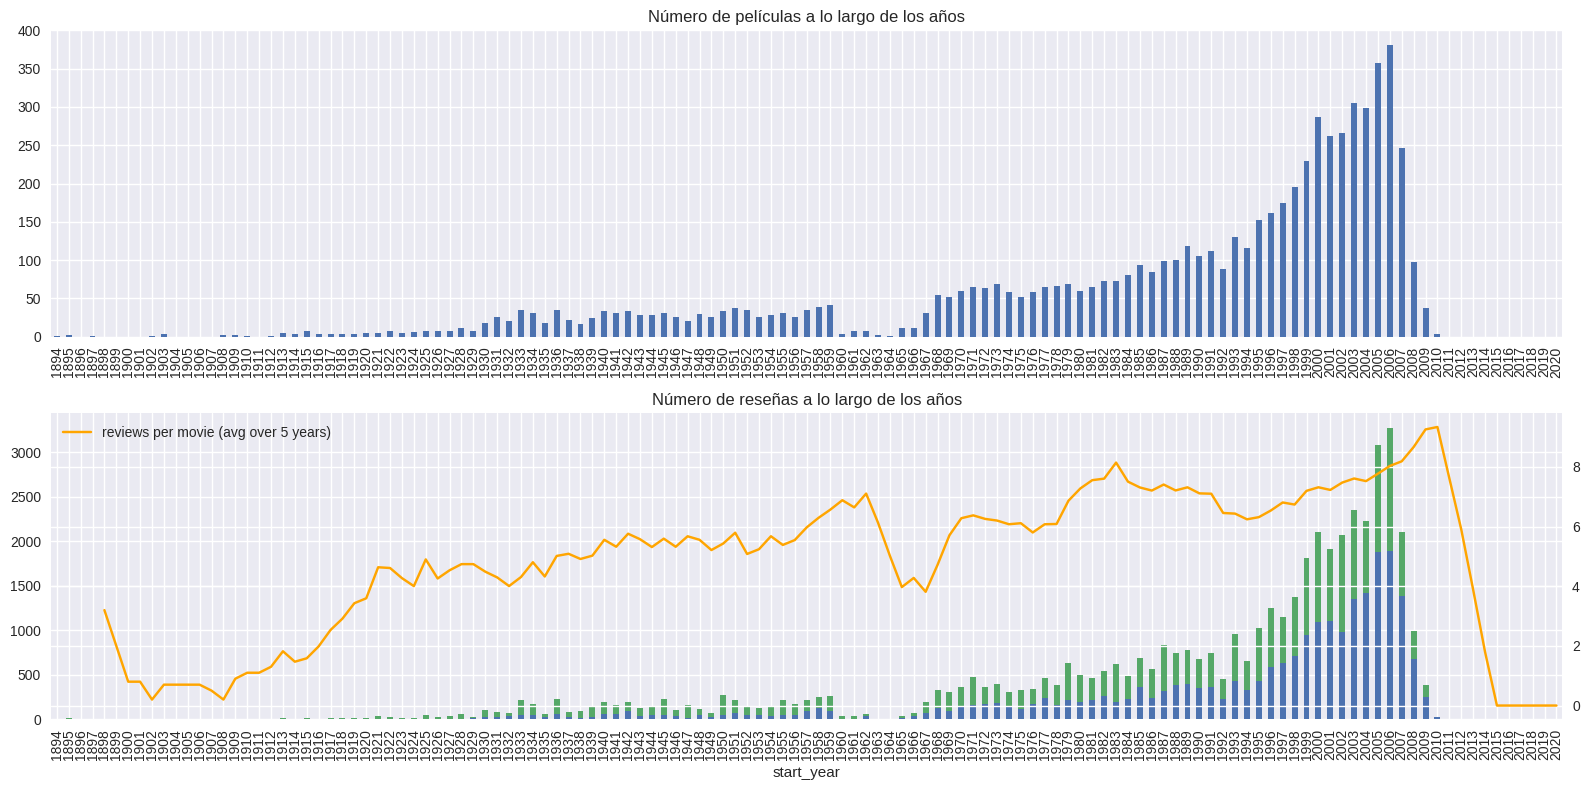

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

***
Si observamos el gráfico anterior, podemos decir que la mayor cantidad de películas se estrenaron en 2005 y 2006, con entre 300 y 400 películas en ambos años. La cantidad de reseñas coincide con la cantidad de películas.
***

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

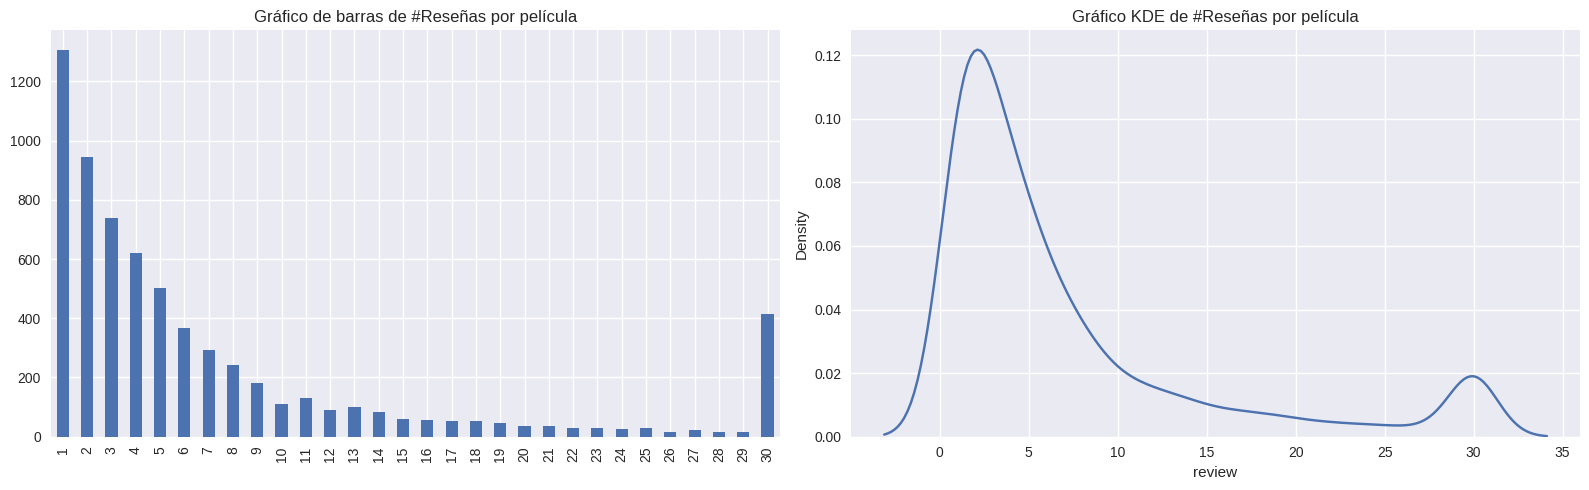

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

***
La mayoría de las películas recibieron una reseña y luego, de manera constante, la cantidad de reseñas por película disminuyó. Sin embargo, alrededor de 400 películas en el conjunto de datos recibieron 30 reseñas.
***

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

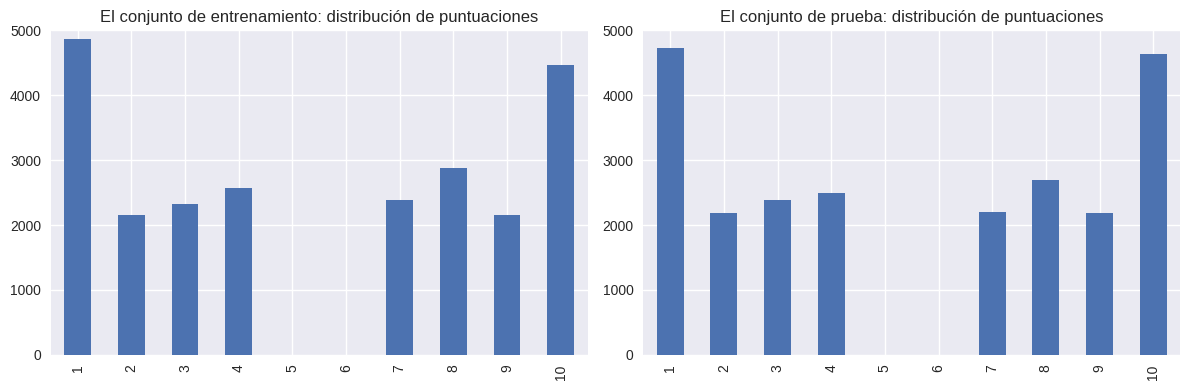

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

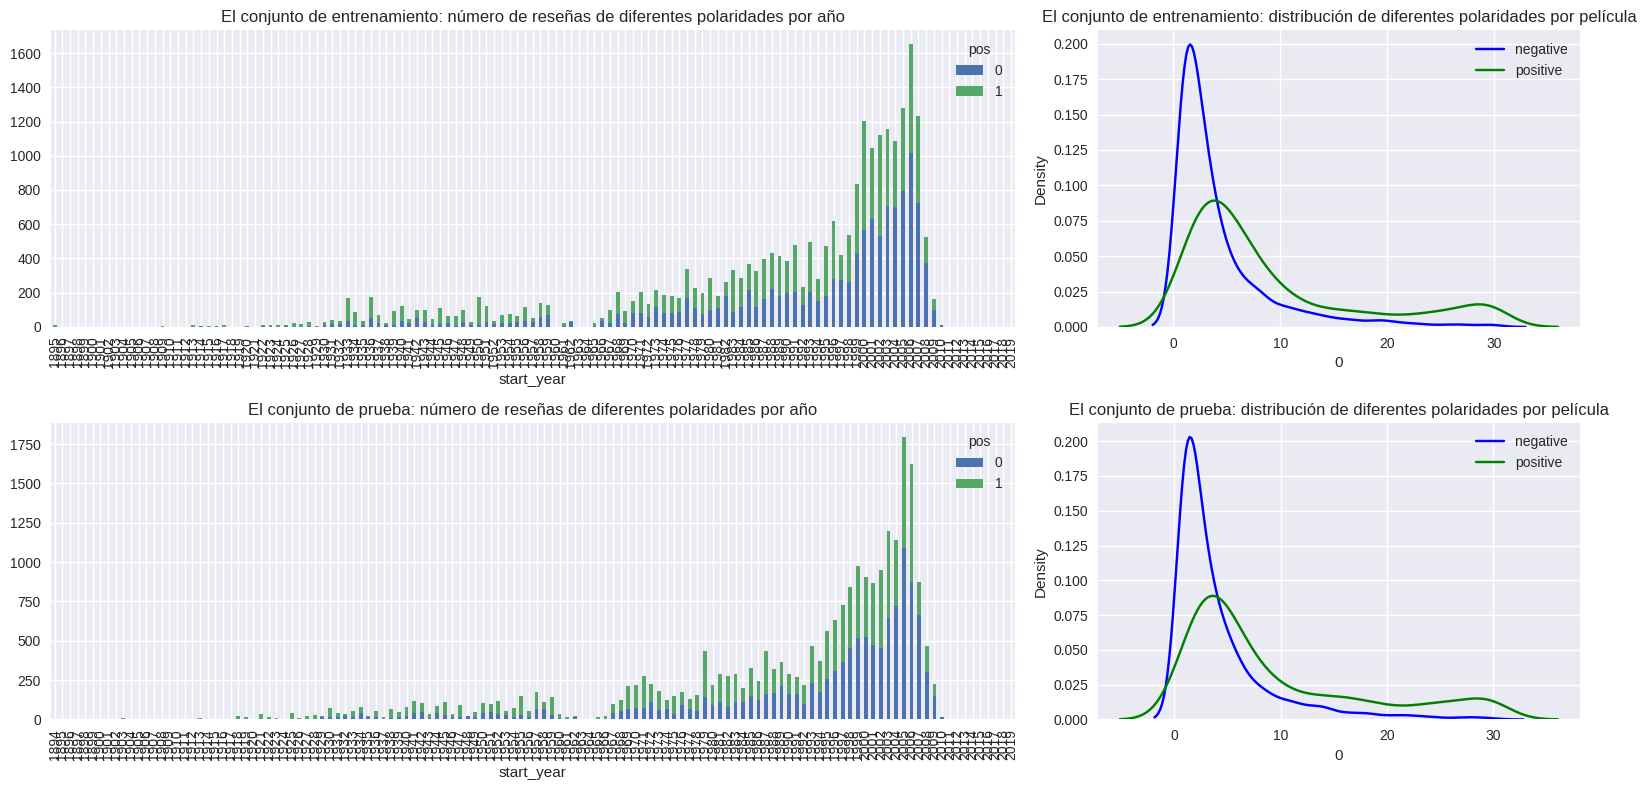

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

***
Como mencioné anteriormente, la distribución de las reseñas positivas y negativas dentro del marco de datos está bien distribuida. Como muestran los gráficos anteriores, esto también es cierto cuando se observa la distribución positiva y negativa de los conjuntos de prueba y de entrenamiento.
***

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [17]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [18]:
lemmatizer  = WordNetLemmatizer()

In [19]:
def clean_reviews(text):
    """
    Limpiar las reseñas

    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\']', ' ', text)
    # text = emoji.get_emoji_regexp().sub(u'', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    #text = " ".join(lemmatizer.lemmatize(word) for word in word_tokenize(text))
    text = re.sub(r'\s+', ' ', text)
    return text

In [20]:
df_reviews['reviews_norm'] = df_reviews['review'].apply(clean_reviews)

***
Veamos un ejemplo antes y después de la lematización.
***

In [21]:
df_reviews.loc[100, 'review']

"Years ago, Sara, a young girl witnessed her parents being murdered, now as an adult she suffers from various mental ailments (did I mention she has an imaginary friend?) This film lulls the viewer, not into a sense of tension, mind you, but rather a sense of sleepiness. Deathly boring, I found it hard to sit through as I could feel my eyelids growing heavier and heavier with each endless minute of mindless prattle and supposed 'mystery'. Is Sara going crazy? or is it the paranormal? A better question would be, Who cares? And the answer to that, no one. No one at all. Skip this film, save yourself some time better suited to do other more worthwhile tasks. My Grade: D-"

In [22]:
df_reviews.loc[100, 'reviews_norm']

"years ago sara a young girl witnessed her parents being murdered now as an adult she suffers from various mental ailments did i mention she has an imaginary friend this film lulls the viewer not into a sense of tension mind you but rather a sense of sleepiness deathly boring i found it hard to sit through as i could feel my eyelids growing heavier and heavier with each endless minute of mindless prattle and supposed 'mystery' is sara going crazy or is it the paranormal a better question would be who cares and the answer to that no one no one at all skip this film save yourself some time better suited to do other more worthwhile tasks my grade d "

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_y = df_reviews_train['pos']
test_y = df_reviews_test['pos']


print('Tamaño de la muestra de entrenamiento:', df_reviews_train.shape)
print('Tamaño de la muestra de prueba:', df_reviews_test.shape)

Tamaño de la muestra de entrenamiento: (23796, 18)
Tamaño de la muestra de prueba: (23535, 18)


In [24]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Construir modelo
    """
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict(train_X)
        best_score = f1_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'lgbm':
        gs.best_estimator_.fit(train_X, train_y, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_score = f1_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

## Trabajar con modelos

### Modelo 0 - Constante

In [51]:
from sklearn.dummy import DummyClassifier

In [52]:
dc = DummyClassifier()
best_dc_model, best_dc_f1, best_dc_time = build_model(dc, df_reviews_train['reviews_norm'], train_y, 
                                                        df_reviews_test['reviews_norm'], test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=2, model_str='dummy')

In [53]:
# conjunto de prueba
best_dc_f1

0.0

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


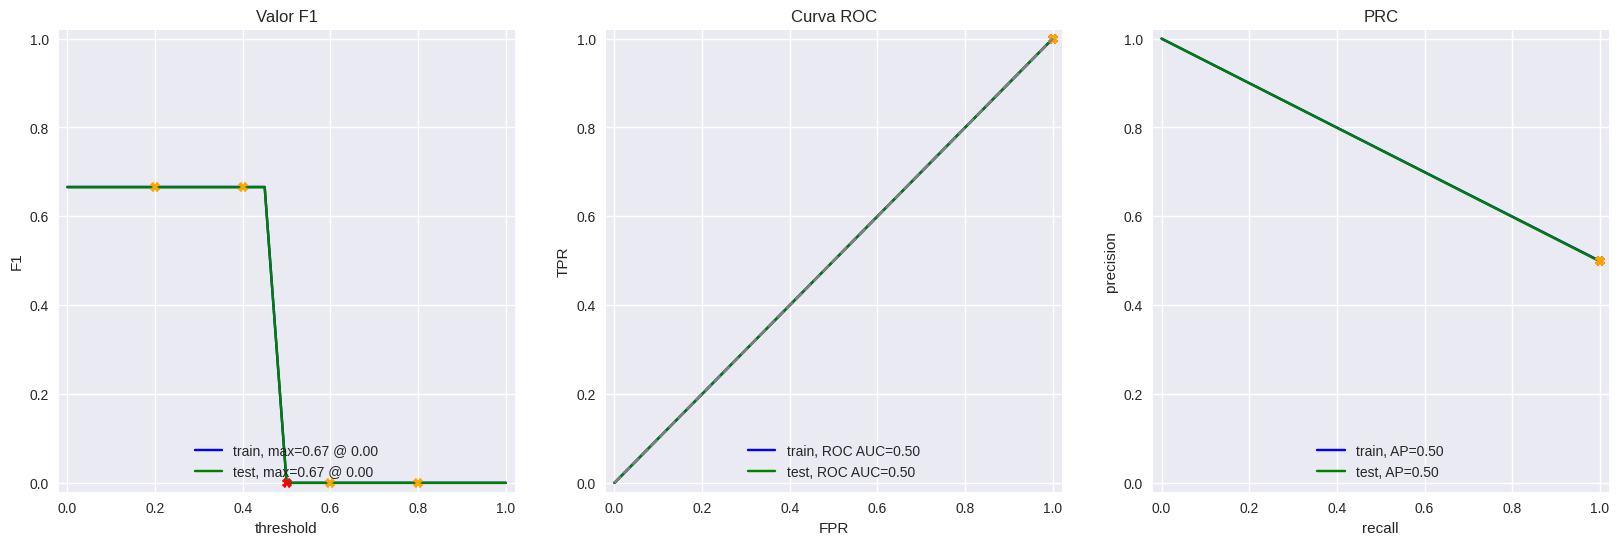

In [54]:
evaluate_model(best_dc_model, df_reviews_train['reviews_norm'], train_y, df_reviews_test['reviews_norm'], test_y)

Como era de esperar, el dummy classifier funciona de forma tan aleatoria como lanzar una moneda.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [55]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def text_preprocessing_1(text):
    """
    Tokenizar y lematizar texto
    """
    tokens = word_tokenize(text)
    return " ".join(lemmatizer.lemmatize(token) for token in tokens)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
%%time
df_reviews_train['reviews_nltk'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_1)
df_reviews_test['reviews_nltk'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_1)

CPU times: user 50.3 s, sys: 28 ms, total: 50.3 s
Wall time: 50.3 s


In [57]:
%%time
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
train_X = tfidf_vectorizer_1.fit_transform(df_reviews_train['reviews_nltk'])
test_X = tfidf_vectorizer_1.transform(df_reviews_test['reviews_nltk'])

CPU times: user 3.76 s, sys: 16 ms, total: 3.77 s
Wall time: 3.78 s


In [58]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
best_lr_model, best_lr_f1, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [59]:
# conjunto de prueba - usando nltk
best_lr_f1

0.8805154903132201

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


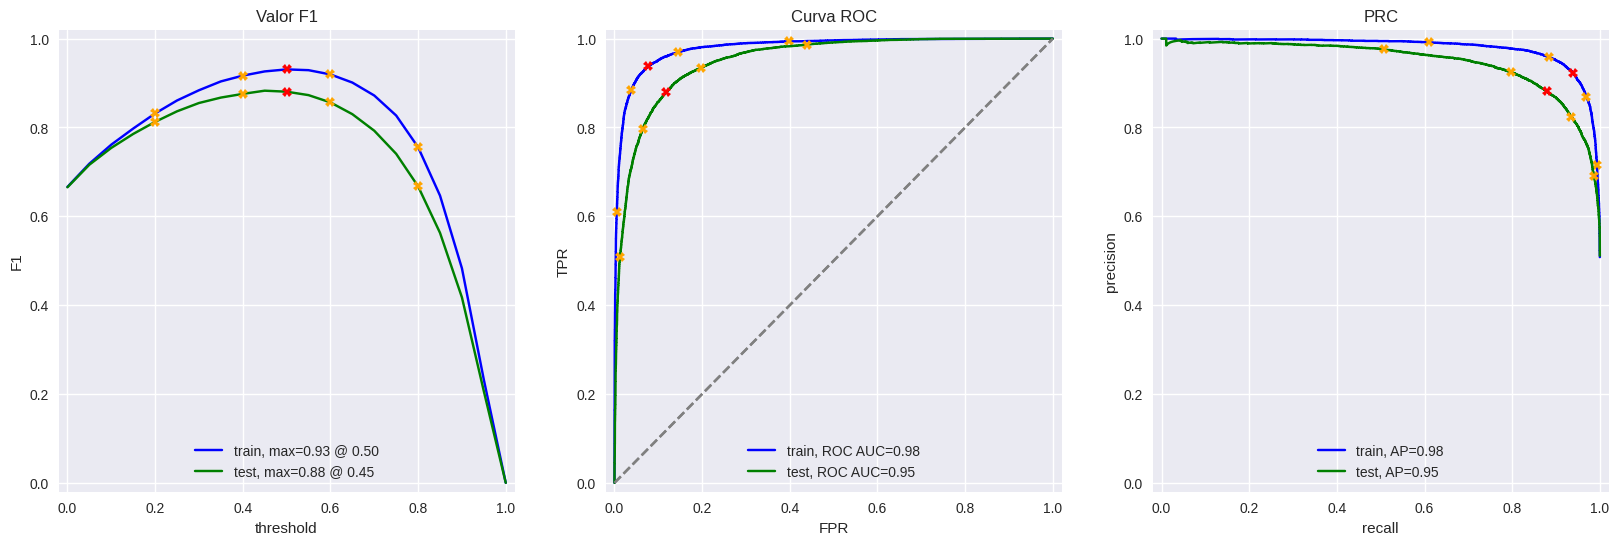

In [60]:
evaluate_model(best_lr_model, train_X, train_y, test_X, test_y)

### Modelo 3 - spaCy, TF-IDF y LR

In [61]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [62]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [63]:
%%time
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
df_reviews_train['reviews_spacy'] = df_reviews_train['reviews_norm'].apply(text_preprocessing_3)
df_reviews_test['reviews_spacy'] = df_reviews_test['reviews_norm'].apply(text_preprocessing_3)

CPU times: user 7min 4s, sys: 111 ms, total: 7min 4s
Wall time: 7min 4s


In [64]:
train_X = tfidf_vectorizer_3.fit_transform(df_reviews_train['reviews_spacy'])
test_X = tfidf_vectorizer_3.transform(df_reviews_test['reviews_spacy'])

In [65]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
best_lr_spacy_model, best_lr_spacy_f1, best_lr_spacy_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [66]:
# conjunto de prueba, usando spacy
best_lr_spacy_f1

0.8785197788175245

          train  test
Accuracy   0.92  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


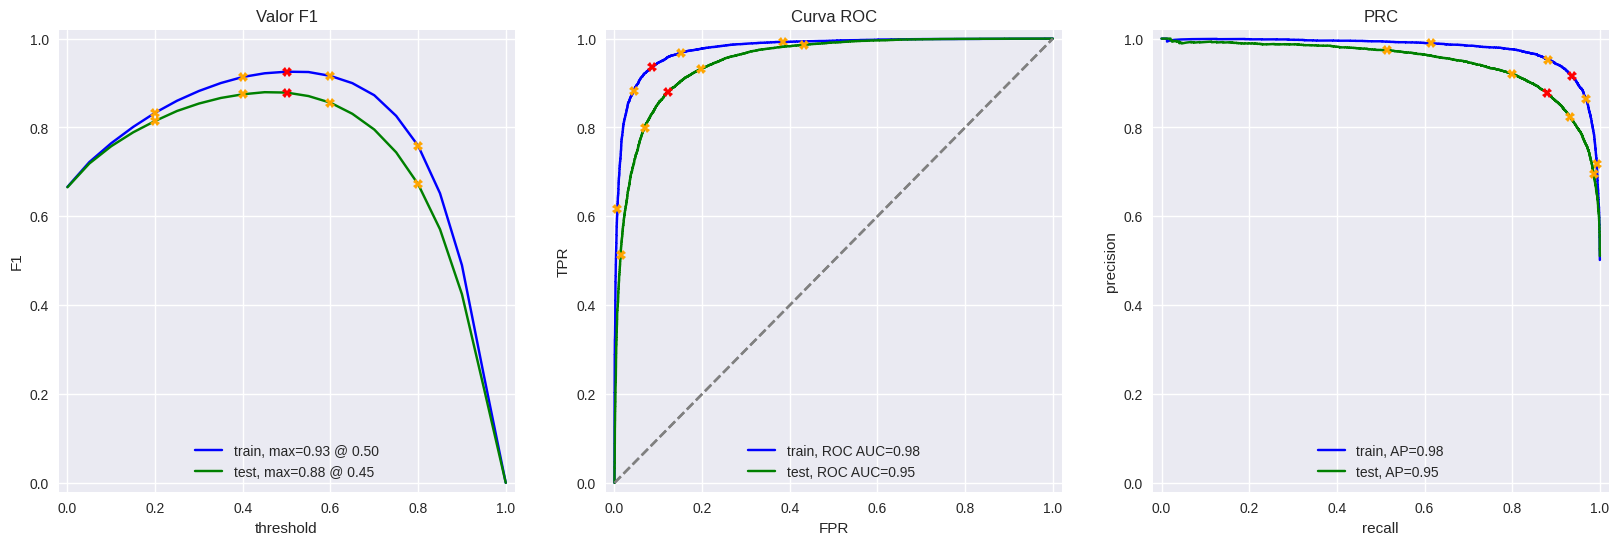

In [67]:
evaluate_model(best_lr_spacy_model, train_X, train_y, test_X, test_y)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [68]:
from lightgbm import LGBMClassifier

In [69]:
%%time
lgbm = LGBMClassifier(learning_rate=0.1, boosting_type='gbdt',
                      objective='binary',
                      random_state=42)
best_lgbm_model, best_lgbm_f1, best_lgbm_time = build_model(lgbm, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100)}, 
                scoring='f1_weighted', cv=3, model_str='lgbm',
           cat_features=[])

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


CPU times: user 15min 47s, sys: 1.57 s, total: 15min 49s
Wall time: 15min 51s


In [70]:
# conjunto de prueba, usando spacy
best_lgbm_f1

0.872733463863114

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.95


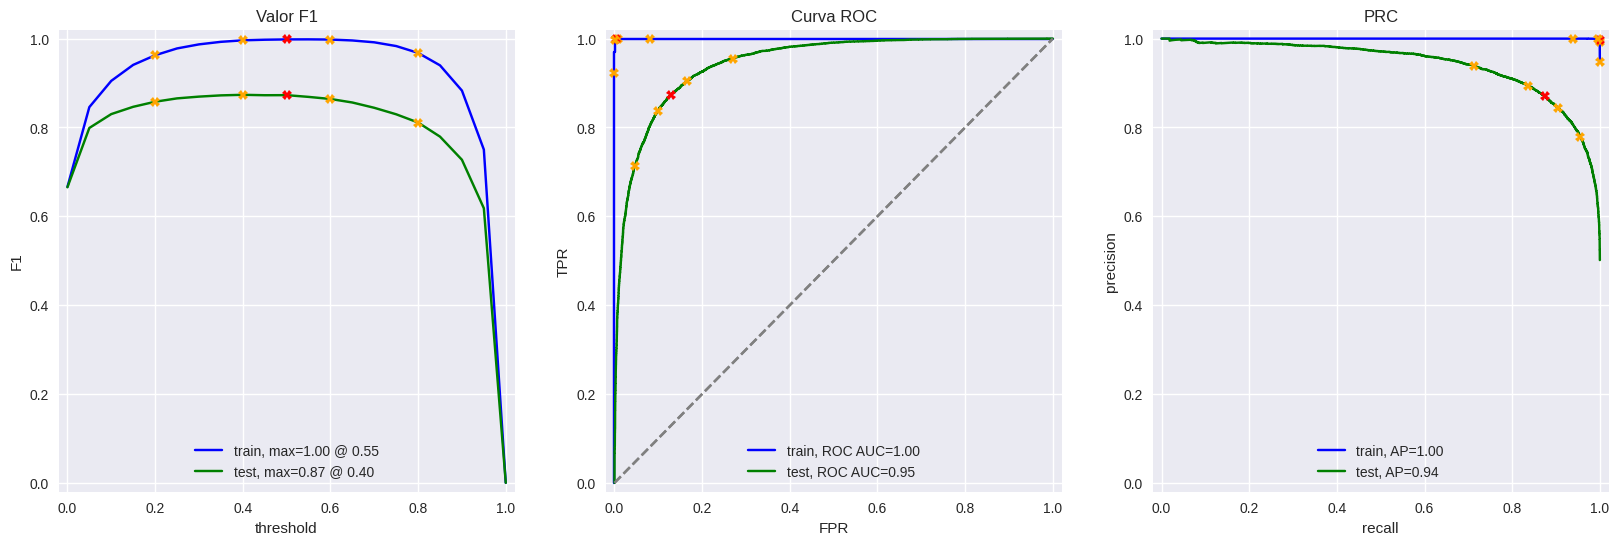

In [71]:
evaluate_model(best_lgbm_model, train_X, train_y, test_X, test_y)

###  Modelo 9 - BERT

In [36]:
import torch
import transformers

In [37]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
def BERT_text_to_embeddings(texts, max_length=100, batch_size=100, force_device="cpu", disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []
    max_sample_size = 2000


    for input_text in df_reviews.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
        

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # obteniendo incrustaciones en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
        
        ids_batch_array = np.array(ids_list[batch_size*i:batch_size*(i+1)])
        ids_batch = torch.LongTensor(ids_batch_array).to(device)
        #ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch_array = np.array(attention_mask_list[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask_batch_array).to(device)
        #attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [39]:
%%time
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas

#train_features_9 = BERT_text_to_embeddings(df_reviews_train['reviews_norm'], force_device='cuda')

train_features_9 = BERT_text_to_embeddings(df_reviews_train['reviews_norm'], force_device='cpu')

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 21min 29s, sys: 9.92 s, total: 21min 39s
Wall time: 21min 39s


In [40]:
print(df_reviews_train['reviews_norm'].shape)
print(train_features_9.shape)
print(train_y.shape)

(23796,)
(2000, 768)
(23796,)


In [44]:
max_sample_size = 2000
features = train_features_9
target = df_reviews.iloc[:max_sample_size]['pos']

print(features.shape)
print(target.shape)

(2000, 768)
(2000,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 768)
(1000, 768)
(1000,)
(1000,)


In [46]:
lr = LogisticRegression(solver='lbfgs', max_iter=2000)
best_lr_bert_model, best_lr_bert_f1, best_lr_bert_time = build_model(lr, X_train, y_train, 
                                                        X_test, y_test,
                                                        hyperparameters={'C' : [.01, .1, 1, 10]}, 
                scoring='f1_weighted', cv=5)

In [47]:
best_lr_bert_f1

0.787434554973822

          train  test
Accuracy   0.88  0.80
F1         0.88  0.79
APS        0.95  0.86
ROC AUC    0.95  0.87


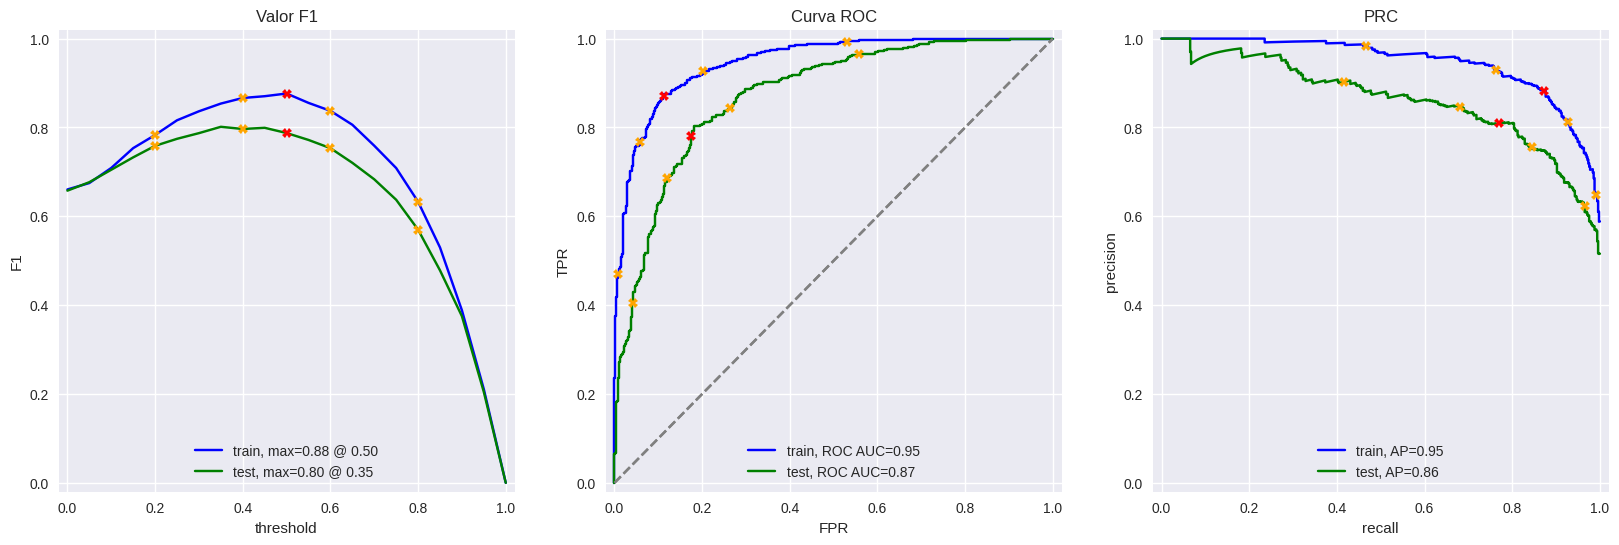

In [48]:
evaluate_model(best_lr_bert_model, X_train, y_train, X_test, y_test)

### Análisis de los modelos

A continuación, compararé la puntuación F1 de los modelos.

In [72]:
model = ['LogisticRegression-NLTK', 'LogisticRegression-Spacy', 'LGBMClassifier-Spacy', 'LogisticRegression-BERT']
best_f1 = [best_lr_f1, best_lr_spacy_f1, best_lgbm_f1, best_lr_bert_f1]
train_time = [best_lr_time, best_lr_spacy_time, best_lgbm_time, best_lr_bert_time]

model_results_df = pd.DataFrame(
    data=zip(model, best_f1, train_time),
    columns=["model", "best_f1", "train_time"],
).sort_values("best_f1", ascending=False)


In [73]:
model_results_df

,model,best_f1,train_time
0,LogisticRegression-NLTK,0.880515,43.59
1,LogisticRegression-Spacy,0.878520,51.61
2,LGBMClassifier-Spacy,0.872733,951.54
3,LogisticRegression-BERT,0.787435,9.76


***
#### Observaciones

1. El modelo con mejor rendimiento según la puntuación F1 fue el modelo LogisticRegression que utiliza NLTK para preprocesar las críticas de películas. Este modelo obtuvo una puntuación F1 de **0,8805**.
2. El segundo modelo con mejor rendimiento fue el modelo LogisticRegression que utiliza Spacy para preprocesar las críticas de películas. Este modelo obtuvo una puntuación F1 de **0,8785**
3. El tercer modelo con mejor rendimiento fue el modelo LightGBM que utiliza Spacy para preprocesar las críticas de películas. Este modelo obtuvo una puntuación F1 de **0,8727**
4. El modelo con peor rendimiento fue el LogisticRegression que utiliza BERT para procesar las críticas de películas. Este modelo obtuvo una puntuación F1 de **0,7874**. Cabe destacar que tuve que reducir el max_sample_size a 2000 debido a limitaciones en la CPU.
***

## Mis reseñas

In [49]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'The movie was hilarious, the actors made me laugh from start to finish of the play',
    'Bad storyline, bad acting, I was really horrified, worst film ever made.',
    "It would be a shame to don't see this movie.",
    'Anyone who is ever watched Sophie Turner on "Game of Thrones" should know that she cannot carry a movie. She is lovely, but has one expression.',
    'A sophomorically conceived film that tries to push every cliched button of the politically correct lunatics that fuel modern Hollywood philosophies. A film that gets into so many false premises that it should have been a black comedy had the filmmakers had the intellectual maturity to satirize such immature writing. Yuk.',
    'What a turkey! A dried up, emaciated and leathery old turkey not even worth cooking. Should have been left for the buzzards. When Pierce Brosnan uttered the zinger when conducting the initial examination, I thought, no way. If this was the premise, why a ham-fisted line like that. Against my better judgement I persisted. Silly me.'
], columns=['review'])

my_reviews['reviews_norm'] = my_reviews['review'].apply(lambda x: x.lower())
my_reviews['reviews_norm'] = my_reviews['reviews_norm'].apply(clean_reviews)

my_reviews

,review,reviews_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,"The movie was hilarious, the actors made me la...",the movie was hilarious the actors made me lau...
9,"Bad storyline, bad acting, I was really horrif...",bad storyline bad acting i was really horrifie...


### Modelo 2 - LogisticRegression-NLTK

In [74]:
texts = my_reviews['reviews_norm'].apply(text_preprocessing_1)

my_reviews_pred_prob = best_lr_model.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie
0.14:  well i wa bored and felt asleep in the middle of the movie
0.49:  i wa really fascinated with the movie
0.13:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.25:  i did n't expect the reboot to be so good writer really cared about the source material
0.56:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod
0.55:  the movie wa hilarious the actor made me laugh from start to finish of the play
0.00:  bad storyline bad acting i wa really horrified worst film ever made
0.22:  it would be a shame to do n't see this movie
0.79:  anyone who is ever watched sophie turner on game of throne should know that she can not 

### Modelo 3 - LogisticRegression-Spacy	

In [75]:
texts = my_reviews['reviews_norm']

my_reviews_pred_prob = best_lr_spacy_model.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.22:  i did not simply like it not my kind of movie 
0.12:  well i was bored and felt asleep in the middle of the movie 
0.51:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.66:  the movie was hilarious the actors made me laugh from start to finish of the play
0.00:  bad storyline bad acting i was really horrified worst film ever made 
0.20:  it would be a shame to don't see this movie 
0.80:  anyone who is ever watched sophie turner on game of thrones should know that she

### Modelo 4 - LGBMClassifier

In [76]:
texts = my_reviews['reviews_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = best_lgbm_model.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  i did not simply like it not my kind of movie 
0.14:  well i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.70:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.14:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.82:  the movie was hilarious the actors made me laugh from start to finish of the play
0.03:  bad storyline bad acting i was really horrified worst film ever made 
0.56:  it would be a shame to don't see this movie 
0.85:  anyone who is ever watched sophie turner on game of thrones should know that she

### Modelo 9 - LogisticRegression-BERT

In [50]:
texts = my_reviews['reviews_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=False)

my_reviews_pred_prob = best_lr_bert_model.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

0.02:  i did not simply like it not my kind of movie 
0.11:  well i was bored and felt asleep in the middle of the movie 
0.48:  i was really fascinated with the movie
0.74:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.65:  i didn't expect the reboot to be so good writers really cared about the source material
0.91:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.29:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.34:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.31:  the movie was hilarious the actors made me laugh from start to finish of the play
0.72:  bad storyline bad acting i was really horrified worst film ever made 
0.27:  it would be a shame to don't see this movie 
0.20:  anyone who is ever watched sophie turner on game of thrones should know that she

***
## Conclusiones

Basándome en los resultados del experimento de creación de modelos utilizando cuatro modelos, aquí están mis conclusiones y recomendaciones.

- **Modelo 2:** NLTK, TF-IDF y LR obtuvo una puntuación F1 de **0.93** (entrenamiento) y **0.88** (prueba)
- **Modelo 3:** spaCy, TF-IDF y LR obtuvo una puntuación F1 de **0.93** (entrenamiento) y **0.878** (prueba)
- **Modelo 4:** spaCy, TF-IDF y LGBM obtuvo una puntuación F1 de **1,00** (entrenamiento) y **0,872** (prueba)
- **Modelo 9:** BERT obtuvo una puntuación F1 de **0.88** (entrenamiento) y **0.787** (prueba)

Los modelos 2, 3 y 4 obtuvieron puntuaciones F1 superiores al umbral de **0,85**.
El modelo LightGBM fue el modelo que obtuvo la puntuación F1 más baja **(0.872)** de los tres y, además, tuvo el tiempo de entrenamiento más alto **(15min 51s)** y, por eso, este modelo será descartado. 

El modelo LogisticRegression fue el modelo que tuvo el mejor rendimiento y se utilizó con los modelos 2, 3 y 9. En términos de procesamiento del lenguaje natural, se utilizaron 3 bibliotecas diferentes: NLTK, spaCy y BERT.
- **NLKT** obtuvo la mejor puntuación en F1 **(0.88)** y fue el segundo más rápido en entrenar **(43.59 s)**
- **spaCy** produjo la segunda mejor puntuación F1 **(0.878)** y también fue el más lento de entrenar **(51.61 s)**
- **BERT** fue el modelo en general que produjo la puntuación F1 más baja **(0.787)** pero fue la más rápida de entrenar **(9.76 s)**. Sin embargo, y esto es muy importante, BERT se entrenó utilizando un tamaño de muestra limitado debido al uso de la CPU. En general, BERT es la biblioteca de procesamiento de lenguaje natural más precisa, pero también la más costosa en términos computacionales; por esa razón, creo que es seguro decir que, si se va a entrenar a BERT con todo el conjunto de datos, BERT superará a los otros modelos. Es sorprendente ver que, a pesar de la puntuación relativamente baja de la F1, algunas de las predicciones realizadas son buenas, mientras que otras obviamente no son del todo correctas. Sin embargo, tampoco puedo decir que las predicciones de los otros modelos sean perfectas. Esperaba que la diferencia en la puntuación de la F1 en comparación con los otros modelos significara que las predicciones del BERT serían más erróneas.

Por lo tanto, mi recomendación es, en términos del análisis realizado, utilizar **NLTK, TF-IDF y LR**. Sin embargo, BERT debería entrenarse utilizando todo el conjunto de datos y, si se obtiene un rendimiento mayor, debería utilizarse en lugar de los otros modelos.
***

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 